In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-08-18 00:00:00+00:00    44801.187500
2021-08-19 00:00:00+00:00    46717.578125
2021-08-20 00:00:00+00:00    49339.175781
2021-08-21 00:00:00+00:00    48905.492188
2021-08-22 00:00:00+00:00    49114.996094
Name: Close, Length: 2528, dtype: float64


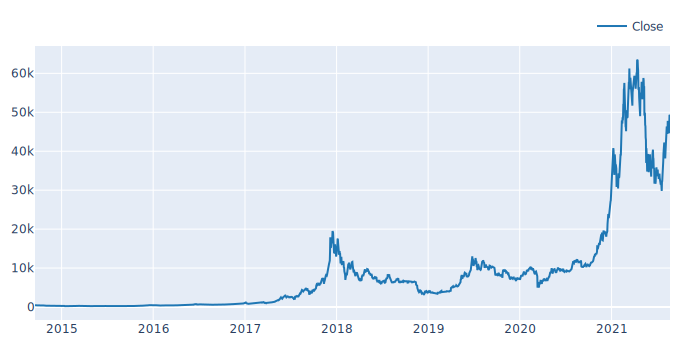

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

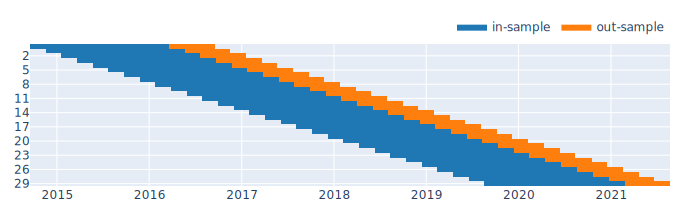

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [9]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()

In [10]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.493885
2     1.576114
3     1.255349
4     1.697116
5     1.646392
6     1.921498
7     2.413538
8     2.419219
9     2.524214
10    3.020101
11    2.557711
12    2.229016
13    2.103502
14    1.852735
15    1.727573
16    0.652773
17    0.485918
18    0.546310
19   -0.209493
20    0.665832
21    0.515329
22    0.432723
23    0.814011
24    0.448828
25    1.333641
26    1.455630
27    1.191392
28    1.220339
29    1.757513
Name: sharpe_ratio, dtype: float64


In [11]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.125426
                          2            0.497444
                          3            0.366434
                          4            0.845251
                                         ...   
48           49           25          -0.066678
                          26          -0.334809
                          27          -1.060989
                          28          -1.006348
                          29          -0.608368
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (19, 27,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (44, 45,  5),
            (23, 25,  6),
            (37, 43,  7),
            (10, 21,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 22, 15),
            (10, 22, 16),
            (10, 22, 17),
            (17, 22, 18),
            (17, 22, 19),
            (13, 21, 20),
            (45, 48, 21),
            (45, 49, 22),
            (18, 21, 23),
            (13, 21, 24),
            (13, 21, 25),
            (13, 20, 26),
            (13, 20, 27),
            (15, 18, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [19 27]
 [21 25]
 [23 25]
 [23 25]
 [44 45]
 [23 25]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [17 22]
 [13 21]
 [45 48]
 [45 49]
 [18 21]
 [13 21]
 [13 21]
 [13 20]
 [13 20]
 [15 18]
 [13 20]]


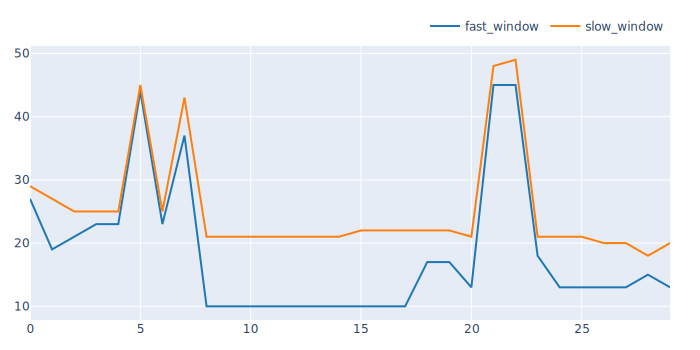

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     2.255167
2     1.605040
3     2.302425
4     3.470567
5     3.312703
6     3.243702
7     3.283377
8     3.136538
9     1.679052
10   -0.073404
11   -0.095784
12   -0.084802
13   -1.756398
14   -1.999851
15   -0.536478
16    2.841116
17    3.610793
18    1.436463
19    0.243803
20   -0.268038
21    0.170627
22    1.103839
23    0.752377
24    2.079782
25    3.695683
26    4.551902
27    4.210304
28    1.090321
29    0.374220
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -0.279485
                          2           -0.097736
                          3            1.209532
                          4            2.518178
                                         ...   
48           49           25           0.821803
                          26           3.585817
                          27           3.448382
                          28           0.412623
                          29          -0.472135
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
19         27         1            0.501229
21         25         2            1.414590
23         25         3            1.031654
                      4            1.431372
44         45         5            0.842915
23         25         6            1.832407
37         43         7           -0.736011
10         21         8            3.442996
                      9            2.907096
                      10           1.142636
                      11           1.553256
                      12           0.663375
                      13           0.112471
                      14           0.030817
           22         15           1.741600
                      16           2.618267
                      17           0.839098
17         22         18           0.698136
                      19          -0.035333
13         21         20           1.250471
45         48         21          -2.579361


In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

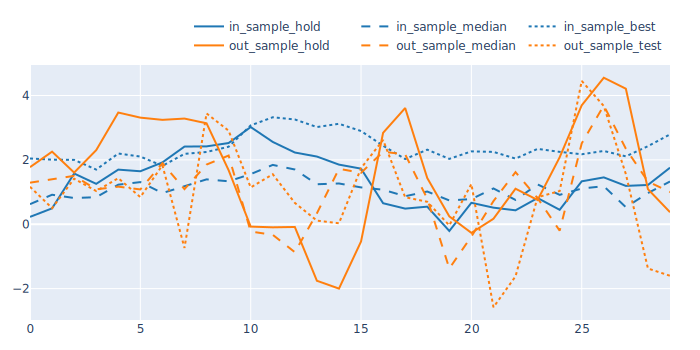

In [23]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()